# Tutorial On Simple Reference Mapping

We compare Geneformer to UCE in this example.

In [3]:
import anndata as ad
import pickle as pkl
import json
from accelerate import Accelerator
import os
from sklearn.model_selection import train_test_split
import json
current_path = os.getcwd()
print(current_path)

/Users/bputzeys/Documents/Helical/Code Repos/helical-package/examples


## Dataset loading and Splitting

Before running this notebook, download the full dataset and model weights from this [link](https://drive.google.com/file/d/1aumr7Ty37bSRz3VPW4U0jNn-qEdrGE6I/view?usp=drive_link).

In [4]:
ann_data = ad.read_h5ad("./data/10k_pbmcs_proc.h5ad")
# mappings = load_mappings(ann_data.var["gene_symbols"])
mappings = pkl.load(open('./data/geneformer/human_gene_to_ensemble_id.pkl', 'rb'))
ann_data.var['ensembl_id'] = ann_data.var['gene_symbols'].apply(lambda x: mappings.get(x,{"id":None})['id'])

X_train, X_test = train_test_split(ann_data,train_size=0.01,test_size=0.005,random_state=0)

## Geneformer Model For Zero Shot Reference Mapping

In [5]:
from helical.models.geneformer.model import Geneformer

with open('./geneformer_config.json') as f:
    config = json.load(f)

accelerator = Accelerator(project_dir=config["data_config"]["dir"], cpu=True)
geneformer = Geneformer(config["model_config"], config["data_config"], config["files_config"],  accelerator=accelerator)

In [6]:
train_dataset = geneformer.process_data(X_train)
test_dataset = geneformer.process_data(X_test)

/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/helical/models/geneformer/geneformer_tokenizer.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id"][coding_miRNA_loc]
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/helical/models/geneformer/geneformer_tokenizer.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id"][coding_miRNA_loc]
2024-04-27, 11:22:48.927 helical.models.geneformer.geneformer_tokenizer INFO Anndata has no column attribute 'filter_pass'; tokenizing all cells.


Creating dataset.


Map (num_proc=4): 100%|██████████| 119/119 [00:00<00:00, 988.36 examples/s]
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/helical/models/geneformer/geneformer_tokenizer.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id"][coding_miRNA_loc]
/Users/bputzeys/miniforge3/envs/

Creating dataset.


Map (num_proc=4): 100%|██████████| 60/60 [00:00<00:00, 720.62 examples/s]
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
ref_embeddings = geneformer.get_embeddings(train_dataset)
test_embeddings = geneformer.get_embeddings(test_dataset)

2024-04-27, 11:22:51.323 Geneformer-Model INFO Inference started
100%|██████████| 24/24 [00:48<00:00,  2.00s/it]
2024-04-27, 11:23:39.439 Geneformer-Model INFO Inference started
100%|██████████| 12/12 [00:25<00:00,  2.14s/it]


<Axes: xlabel='px', ylabel='py'>

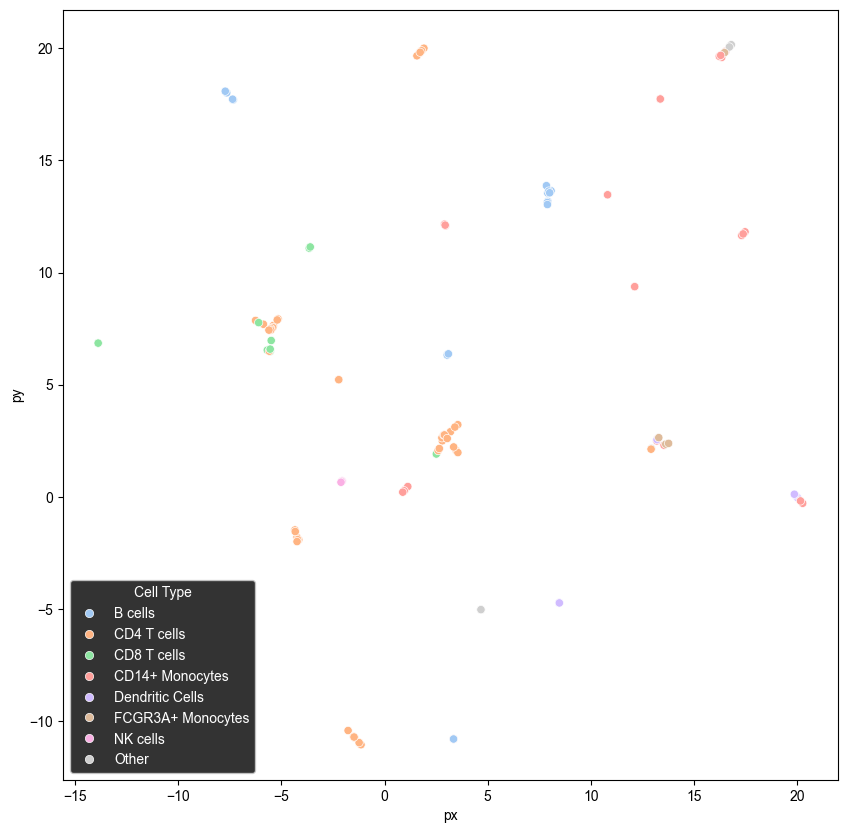

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd

reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']
# ax = umap.plot.points(mapper,labels=labels_pf,ax=ax,theme='viridis')

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")

In [9]:
from sklearn.neighbors import KNeighborsClassifier
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

KNeighborsClassifier(metric='cosine')

In [10]:
pred_labels = neigh.predict(test_embeddings)

Text(0.5, 1.0, 'Geneformer - KNN Classification')

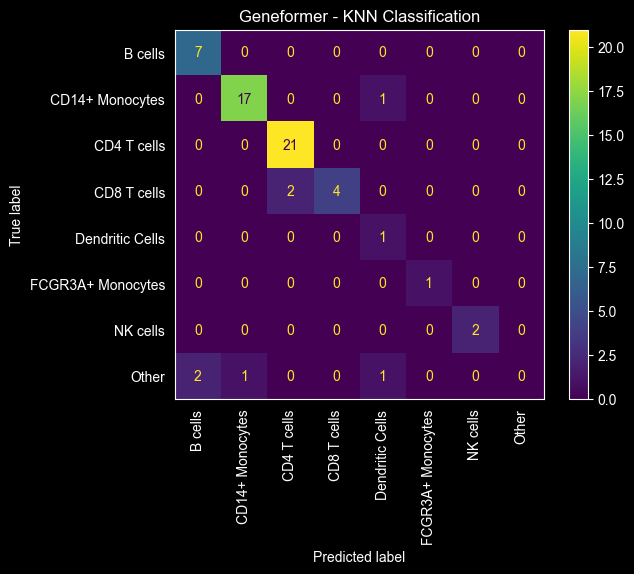

In [11]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")

In [12]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       0.78      1.00      0.88         7
  CD14+ Monocytes       0.94      0.94      0.94        18
      CD4 T cells       0.91      1.00      0.95        21
      CD8 T cells       1.00      0.67      0.80         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       0.00      0.00      0.00         4

         accuracy                           0.88        60
        macro avg       0.75      0.83      0.76        60
     weighted avg       0.85      0.88      0.86        60



/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bputzeys/miniforge3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

## UCE Model For Zero Shot Reference Mapping

In [13]:
from helical.models.uce.model import UCE

with open('./uce_config.json') as f:
    config = json.load(f)

accelerator = Accelerator(project_dir=config["data_config"]["dir"])
uce = UCE(config["model_config"],
          config["data_config"],
          config["files_config"],
          accelerator=accelerator)

In [14]:
train_data = uce.process_data(X_train,species=config["data_config"]["species"])
ref_embeddings = uce.get_embeddings(train_data)

2024-04-27, 11:24:38.329 helical.models.uce.gene_embeddings INFO Finished loading gene embeddings for {'human'} from data/uce/model_files/protein_embeddings
2024-04-27, 11:24:38.343 helical.models.uce.gene_embeddings INFO Filtered out 0 genes to a total of 12000 genes with embeddings.
2024-04-27, 11:24:38.822 helical.models.uce.uce_utils INFO Passed the gene expressions (with shape=(119, 12000) and max gene count data 426.0) to ./test_counts.npz
2024-04-27, 11:24:39.835 helical.models.uce.uce_utils INFO UCEDataset and DataLoader prepared. Setting batch_size=5 for inference.
2024-04-27, 11:24:39.836 UCE-Model INFO Inference started
100%|██████████| 24/24 [00:44<00:00,  1.86s/it]


<Axes: xlabel='px', ylabel='py'>

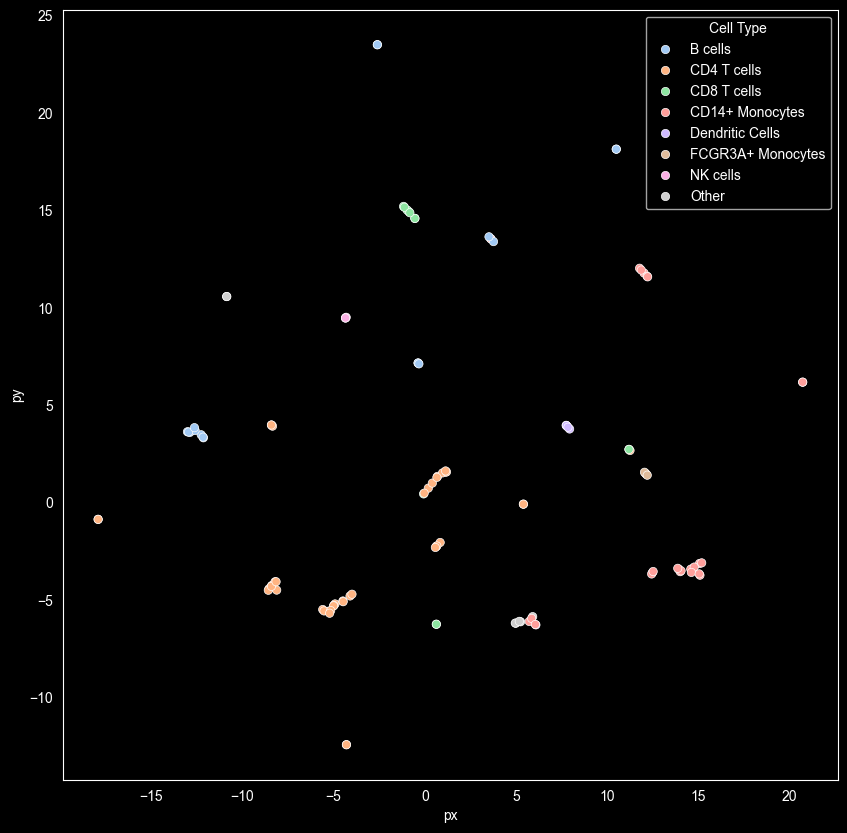

In [15]:
reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(ref_embeddings)

labels = X_train.obs['cell_type']
# ax = umap.plot.points(mapper,labels=labels_pf,ax=ax,theme='viridis')

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")

In [16]:
test_data = uce.process_data(X_test,species=config["data_config"]["species"])
test_embeddings = uce.get_embeddings(test_data)

2024-04-27, 11:25:58.166 helical.models.uce.gene_embeddings INFO Finished loading gene embeddings for {'human'} from data/uce/model_files/protein_embeddings
2024-04-27, 11:25:58.172 helical.models.uce.gene_embeddings INFO Filtered out 0 genes to a total of 12000 genes with embeddings.
2024-04-27, 11:25:58.601 helical.models.uce.uce_utils INFO Passed the gene expressions (with shape=(60, 12000) and max gene count data 344.0) to ./test_counts.npz
2024-04-27, 11:25:59.649 helical.models.uce.uce_utils INFO UCEDataset and DataLoader prepared. Setting batch_size=5 for inference.
2024-04-27, 11:25:59.650 UCE-Model INFO Inference started
100%|██████████| 12/12 [00:22<00:00,  1.88s/it]


In [17]:
labels = X_train.obs['cell_type']
neigh = KNeighborsClassifier(n_neighbors=5,metric='cosine') 
neigh.fit(ref_embeddings, labels)

pred_labels = neigh.predict(test_embeddings)

Text(0.5, 1.0, 'UCE - KNN Classification')

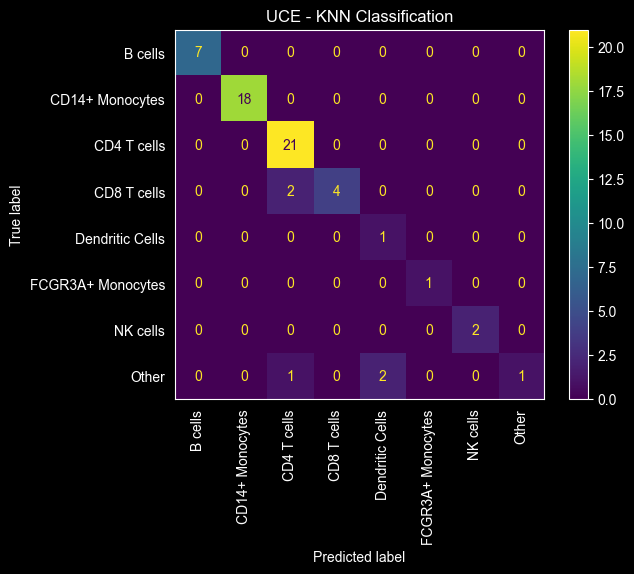

In [18]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(X_test.obs['cell_type'],pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(xticks_rotation="vertical")
plt.title("UCE - KNN Classification")

In [19]:
print(classification_report(X_test.obs['cell_type'],pred_labels))

                   precision    recall  f1-score   support

          B cells       1.00      1.00      1.00         7
  CD14+ Monocytes       1.00      1.00      1.00        18
      CD4 T cells       0.88      1.00      0.93        21
      CD8 T cells       1.00      0.67      0.80         6
  Dendritic Cells       0.33      1.00      0.50         1
FCGR3A+ Monocytes       1.00      1.00      1.00         1
         NK cells       1.00      1.00      1.00         2
            Other       1.00      0.25      0.40         4

         accuracy                           0.92        60
        macro avg       0.90      0.86      0.83        60
     weighted avg       0.95      0.92      0.91        60

